# Train RF for Nutri-Score
Hyperparameter tuning

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [3]:
# 1. Load data
train = pd.read_csv("../gen/data_def_train_folds.csv")
test  = pd.read_csv("../gen/data_def_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

C:\Users\Voorro\AppData\Local\Temp\ipykernel_24776\1890095929.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data_def_train_folds.csv")


Train shape: (206068, 24)
Test shape: (88315, 23)


C:\Users\Voorro\AppData\Local\Temp\ipykernel_24776\1890095929.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test  = pd.read_csv("data_def_test.csv")


In [4]:
# 2. Create combined column for Phase 2 (intrinsic + extrinsic)
train["labels_1_2_intr_extr"] = (
    train[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

test["labels_1_2_intr_extr"] = (
    test[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

In [5]:
train.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,nova_group_fold,nutriscore_fold,labels_1_2_intr_extr
0,554004509,Pain de mie sans gluten,c,4,3.1 Bread,NO_GLUTEN|NO_PRESERVATIVES,2,NO_GLUTEN|NO_PRESERVATIVES,2,NaN,...,2.0,22.0,3. Cereals & Starches,1,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|NO_PRESERVATIVES
1,2000002466,2 MINI BAGUETTES SANS GLUTEN,c,4,3.1 Bread,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,5,NO_GLUTEN,1,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,...,2.0,15.0,3. Cereals & Starches,2,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_O...
2,2000003197,Véritable Andouille de Guémené,e,4,5.1 Processed meat,SMOKED_BEECH_WOOD,1,SMOKED_BEECH_WOOD,1,NaN,...,2.0,10.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 4","5. Meat, Fish & Eggs | 4",train,1,1,SMOKED_BEECH_WOOD
3,2000010775,Escalope soja et blé,b,3,5.4 Meat,EVU_VEGETARIAN|VEGETARIAN,2,NaN,0,EVU_VEGETARIAN|VEGETARIAN,...,0.0,32.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 3","5. Meat, Fish & Eggs | 3",train,1,3,EVU_VEGETARIAN|VEGETARIAN
4,8112100281,Pure Sesame Oil,c,2,6.1 Fats & oils,NON_GMO,1,NaN,0,NON_GMO,...,0.0,1.0,6. Fats & Sauces,1,6. Fats & Sauces | 2,6. Fats & Sauces | 2,train,4,4,NON_GMO


In [6]:
test.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,countries,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,core_slice,labels_1_2_intr_extr
0,790200123,"Fine Chocolate Candy Bar, Dark Chocolate",c,4,9.3 Chocolate products,NO_GLUTEN,1,NO_GLUTEN,1,NaN,...,united-states,2.0,8.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,NO_GLUTEN
1,2000001780,Pizza Margherita,c,3,"7.2 Pizza, pies and quiche",EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,france,0.0,35.0,7. Composite & Prepared Meals,1,7. Composite & Prepared Meals | 3,7. Composite & Prepared Meals | 3,test,False,EU_ORGANIC_LOGO
2,3004032145,Chinois Nature Décongelé,e,4,9.2 Pastries,UNFROZEN,1,UNFROZEN,1,NaN,...,france,11.0,48.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,UNFROZEN
3,8005158306,"Nuovo Pasta, Organic Ravioli, Butternut Squash",a,4,2.5 Potatoes,EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,united-states,1.0,33.0,2. Fruits & Vegetables,1,2. Fruits & Vegetables | 4,2. Fruits & Vegetables | 4,test,False,EU_ORGANIC_LOGO
4,8295663177,Balsamic Vinegar Of Modena,c,4,6.2 Dressings and sauces,NON_GMO,1,NaN,0,NON_GMO,...,united-states|world,0.0,3.0,6. Fats & Sauces,1,6. Fats & Sauces | 4,6. Fats & Sauces | 4,test,False,NON_GMO


In [7]:
# 3. Target + folds
target = "nutriscore"
fold_col = f"{target}_fold" 

# Encode target variable
le = LabelEncoder()
y_train = le.fit_transform(train[target])
y_test = le.transform(test[target])

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}


In [8]:
# 4. Define phases (name -> column)
phases = {
    "phase1_intrinsic": "labels_1_intrinsic",
    "phase2_intr+extr": "labels_1_2_intr_extr",
    "phase3_all_labels": "labels_string",
}

In [9]:
# 5. Define Random Forest hyperparameter grid
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

all_phase_results = []
all_best_params = []


=== phase1_intrinsic – Using column 'labels_1_intrinsic' ===


D:\ProgramFilesFolder\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'ENRICHED_WITH_OMEGA3', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'KETOGENIC', 'LOW_FODMAP', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COLORANT_AROMA_PRESERVATIVE', 'NO_DYES_PRESERVATIVES_HYDROGENATED_FATS', 'NO_EXTRACTS', 'NO_FRUIT', 'NO_GARLIC_ONION', 'NO_GLUTEN_COLORANT_PRESERVATIVE', 'NO_HIGH_PRESSURE_PROCESSING', 'NO_HONEY', 'NO_LARD', 'NO_METAL_MOLD', 'NO_NUT_TRACES', 'NO_PALM_OIL_DERIVATIVES', 'NO_PHOSPHORIC_ACID', 'NO_POTATO_FLAKE

Encoded label matrix shape (train): (206068, 359)
Encoded label matrix shape (test):  (88315, 359)

>>> Hyperparameter search using predefined 5-fold CV
Total CV iterations: 720


Cross-validation (nutriscore):   0%|                              | 0/720 [00:00<?, ?it/s]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


Cross-validation (nutriscore):   0%|                              | 0/720 [47:32<?, ?it/s]



Best parameters for phase1_intrinsic:
  class_weight: balanced
  max_depth: None
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 50
Best 5-fold balanced accuracy (on train CV): 0.2621
Hyperparameter search time: 2852.04 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase1_intrinsic (Nutri-Score) ===
Accuracy:           0.2450
Balanced Accuracy:  0.2617
Precision (Macro):  0.3171
Recall (Macro):     0.2617
F1 (Macro):         0.2046
F1 (Micro):         0.2450
Train time (full train):   12.08 s
Predict time (test set):   2.59 s

Detailed Classification Report:
              precision    recall  f1-score   support

           a       0.19      0.79      0.30     14047
           b       0.29      0.05      0.09     11057
           c       0.36      0.13      0.19     20236
           d       0.39      0.09      0.15     20659
           e       0.36      0.24      0.29     22316

    accuracy               

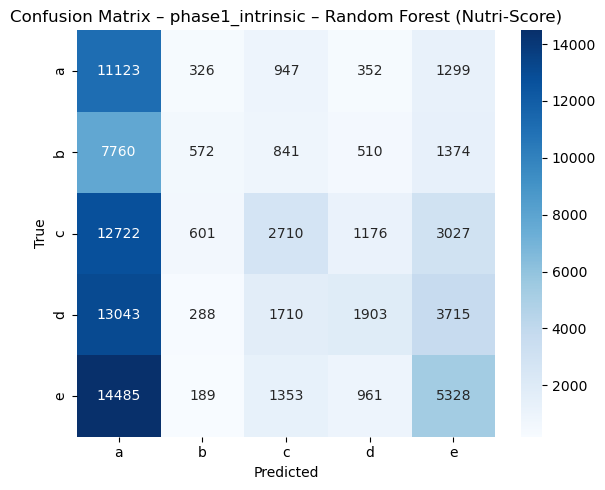


=== phase2_intr+extr – Using column 'labels_1_2_intr_extr' ===


D:\ProgramFilesFolder\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COLORAN

Encoded label matrix shape (train): (206068, 808)
Encoded label matrix shape (test):  (88315, 808)

>>> Hyperparameter search using predefined 5-fold CV
Total CV iterations: 720


Cross-validation (nutriscore):   0%|                              | 0/720 [00:00<?, ?it/s]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


Cross-validation (nutriscore):   0%|                            | 0/720 [1:57:48<?, ?it/s]



Best parameters for phase2_intr+extr:
  class_weight: balanced
  max_depth: None
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100
Best 5-fold balanced accuracy (on train CV): 0.3625
Hyperparameter search time: 7068.10 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase2_intr+extr (Nutri-Score) ===
Accuracy:           0.3773
Balanced Accuracy:  0.3634
Precision (Macro):  0.3611
Recall (Macro):     0.3634
F1 (Macro):         0.3455
F1 (Micro):         0.3773
Train time (full train):   112.40 s
Predict time (test set):   4.46 s

Detailed Classification Report:
              precision    recall  f1-score   support

           a       0.34      0.52      0.41     14047
           b       0.26      0.18      0.21     11057
           c       0.38      0.29      0.33     20236
           d       0.41      0.21      0.28     20659
           e       0.42      0.62      0.50     22316

    accuracy             

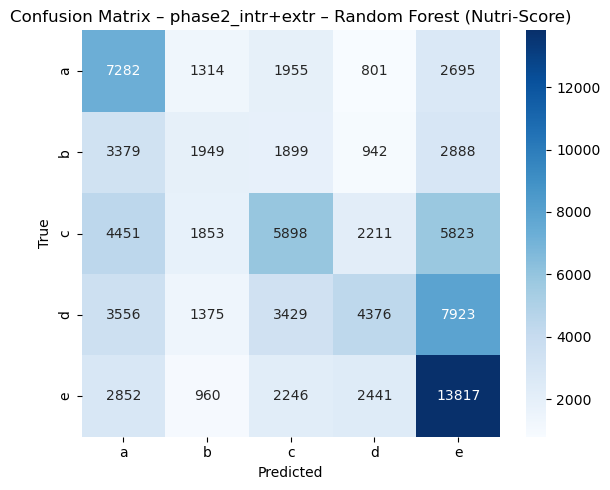


=== phase3_all_labels – Using column 'labels_string' ===


D:\ProgramFilesFolder\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CARREFOUR_CLASSIC', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'GOLD_MEDAL_GENERIC', 'GOLD_MEDAL_MILK_GRADE_A', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_IN

Encoded label matrix shape (train): (206068, 870)
Encoded label matrix shape (test):  (88315, 870)

>>> Hyperparameter search using predefined 5-fold CV
Total CV iterations: 720


Cross-validation (nutriscore):   0%|                              | 0/720 [00:00<?, ?it/s]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


Cross-validation (nutriscore):   0%|                            | 0/720 [2:09:03<?, ?it/s]



Best parameters for phase3_all_labels:
  class_weight: balanced
  max_depth: None
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100
Best 5-fold balanced accuracy (on train CV): 0.3676
Hyperparameter search time: 7743.29 s

>>> Final model training on full training data & test evaluation

=== Test Performance – phase3_all_labels (Nutri-Score) ===
Accuracy:           0.3798
Balanced Accuracy:  0.3687
Precision (Macro):  0.3620
Recall (Macro):     0.3687
F1 (Macro):         0.3548
F1 (Micro):         0.3798
Train time (full train):   126.84 s
Predict time (test set):   4.27 s

Detailed Classification Report:
              precision    recall  f1-score   support

           a       0.34      0.51      0.41     14047
           b       0.26      0.21      0.23     11057
           c       0.37      0.32      0.34     20236
           d       0.40      0.23      0.29     20659
           e       0.44      0.58      0.50     22316

    accuracy           

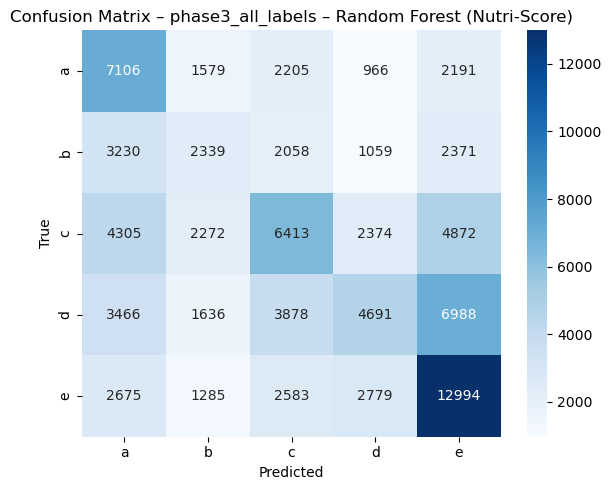

In [10]:
# 6. Loop over phases
for phase_name, label_col in phases.items():
    print("\n" + "="*90)
    print(f"=== {phase_name} – Using column '{label_col}' ===")
    print("="*90)

    # 6.1 Encode label features for this phase
    train[label_col] = train[label_col].fillna("")
    test[label_col]  = test[label_col].fillna("")

    train_labels = train[label_col].apply(lambda x: x.split("|") if x != "" else [])
    test_labels  = test[label_col].apply(lambda x: x.split("|") if x != "" else [])

    mlb = MultiLabelBinarizer(sparse_output=True)
    X_train_labels = mlb.fit_transform(train_labels)
    X_test_labels  = mlb.transform(test_labels)

    print(f"Encoded label matrix shape (train): {X_train_labels.shape}")
    print(f"Encoded label matrix shape (test):  {X_test_labels.shape}")

    # 6.2 Hyperparameter tuning with own predefined 5 folds
    print("\n>>> Hyperparameter search using predefined 5-fold CV")

    # Map fold column (1..5) to 0..4 for PredefinedSplit
    fold_ids = train[fold_col].values
    test_fold = fold_ids - 1   # now in {0,1,2,3,4}
    ps = PredefinedSplit(test_fold=test_fold)

    base_rf = RandomForestClassifier(
        random_state=42
    )

    grid = GridSearchCV(
        estimator=base_rf,
        param_grid=rf_param_grid,
        cv=ps,                            
        scoring="balanced_accuracy",
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Progress bar
    param_list = list(ParameterGrid(rf_param_grid))
    total_iterations = len(param_list) * ps.get_n_splits()
    print(f"Total CV iterations: {total_iterations}")
    
    pbar = tqdm(total=total_iterations, desc=f"Cross-validation ({target})", ncols=90)
    
    # Define a small callback to update tqdm as fits complete
    def update_progress(*args, **kwargs):
        pbar.update(1)
    
    # Grid search fit
    grid_start = time.perf_counter()
    grid.fit(X_train_labels, y_train)
    grid_end = time.perf_counter()
    
    pbar.close()
    grid_time = grid_end - grid_start

    best_params = grid.best_params_
    best_score = grid.best_score_

    print(f"\nBest parameters for {phase_name}:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"Best 5-fold balanced accuracy (on train CV): {best_score:.4f}")
    print(f"Hyperparameter search time: {grid_time:.2f} s")

    all_best_params.append({
        "Phase": phase_name,
        **best_params,
        "CV_BalAcc": best_score,
        "Hyperparam Time (s)": grid_time
    })

    # 6.3 Train final model on full train, evaluate on test
    print("\n>>> Final model training on full training data & test evaluation")

    rf_final = RandomForestClassifier(
        random_state=42,
        **best_params
    )

    # Train
    train_start = time.perf_counter()
    rf_final.fit(X_train_labels, y_train)
    train_end = time.perf_counter()
    train_time = train_end - train_start

    # Predict
    pred_start = time.perf_counter()
    y_pred_test = rf_final.predict(X_test_labels)
    pred_end = time.perf_counter()
    pred_time = pred_end - pred_start

    # Metrics
    acc_test = accuracy_score(y_test, y_pred_test)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    precision_macro = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)

    print(f"\n=== Test Performance – {phase_name} (Nutri-Score) ===")
    print(f"Accuracy:           {acc_test:.4f}")
    print(f"Balanced Accuracy:  {bal_acc_test:.4f}")
    print(f"Precision (Macro):  {precision_macro:.4f}")
    print(f"Recall (Macro):     {recall_macro:.4f}")
    print(f"F1 (Macro):         {f1_macro:.4f}")
    print(f"F1 (Micro):         {f1_micro:.4f}")
    print(f"Train time (full train):   {train_time:.2f} s")
    print(f"Predict time (test set):   {pred_time:.2f} s")

    class_names = [str(c) for c in le.classes_]

    print("\nDetailed Classification Report:")
    print(classification_report(
        y_test,
        y_pred_test,
        target_names=class_names,
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {phase_name} – Random Forest (Nutri-Score)")
    plt.tight_layout()
    plt.show()

    # Store results for this phase
    all_phase_results.append({
        "Phase": phase_name,
        "CV_BalAcc": best_score,
        "Test_Accuracy": acc_test,
        "Test_BalAccuracy": bal_acc_test,
        "Precision (Macro)": precision_macro,
        "Recall (Macro)": recall_macro,
        "F1 (Macro)": f1_macro,
        "F1 (Micro)": f1_micro,
        "Train Time (s)": train_time,
        "Predict Time (s)": pred_time,
        "Hyperparam Time (s)": grid_time
    })

In [11]:
# 7. Summary tables
results_df = pd.DataFrame(all_phase_results)
best_params_df = pd.DataFrame(all_best_params)

print("\n=== Summary – Test Performance per Phase (Random Forest, Nutri-Score) ===")
print(results_df)

print("\n=== Best Hyperparameters per Phase ===")
print(best_params_df)

# Save to CSV for thesis reporting
results_df.to_csv("../results/rf_nutriscore_test_results.csv", index=False)
best_params_df.to_csv("../results/rf_nutriscore_best_params.csv", index=False)


=== Summary – Test Performance per Phase (Random Forest, Nutri-Score) ===
               Phase  CV_BalAcc  Test_Accuracy  Test_BalAccuracy  \
0   phase1_intrinsic   0.262123       0.244987          0.261672   
1   phase2_intr+extr   0.362462       0.377308          0.363421   
2  phase3_all_labels   0.367564       0.379811          0.368733   

   Precision (Macro)  Recall (Macro)  F1 (Macro)  F1 (Micro)  Train Time (s)  \
0           0.317119        0.261672    0.204639    0.244987       12.075120   
1           0.361081        0.363421    0.345513    0.377308      112.403199   
2           0.361967        0.368733    0.354796    0.379811      126.837488   

   Predict Time (s)  Hyperparam Time (s)  
0          2.587471          2852.040832  
1          4.458429          7068.096418  
2          4.272514          7743.290949  

=== Best Hyperparameters per Phase ===
               Phase class_weight max_depth max_features  min_samples_leaf  \
0   phase1_intrinsic     balanced      No